DIVA

In [1]:
%matplotlib inline
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr, shapiro, anderson
from scipy.spatial import ConvexHull
import matplotlib.ticker as ticker
from exploration.data.data import load_sim_h5
from results_utils import *
from exploration.algorithm.utils.logging import read_config_log

colors_ = ['firebrick', 'darkgreen', 'navy',  'deepskyblue', 'm','goldenrod', 'black', 'grey']

def create_dict(groups_k):
    return {k[0] + '_' + k[1]: [] for k in groups_k}

def incremental_mean(arr_):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(n_samples):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    out = np.array(out).flatten()
    return out

def moving_av(arr_, win_sz):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(win_sz):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    for i in range(win_sz,n_samples):
        sum_ = sum_ + arr_[i] - arr_[i-win_sz]
        out += [sum_/win_sz]
    out = np.array(out).flatten()
    return out

def std_markers(ax,y,m,sz,color='b'):
    plt.sca(ax)
    for i,(y_,ms_) in enumerate(zip(y,sz)):
        plt.plot(i, y_, marker = m, ms = ms_, color = color)
        
def get_stat_test(dict_):
    thresh = []
    values  = []
    for key in dict_.keys():
        if 'autonomous' in key:
            continue
        values += [dict_[key]]
        key = key.split('&')
        key[0] = key[0].replace('_','.')
        thresh += [float(key[0])]

    return pearsonr(thresh, values)

In [2]:
n_samples = 102000
# Group by:
type_ops = ['proprio']
mode_ops = ['social_96','social1','autonomous']

groups_k = list(itertools.product(type_ops, mode_ops)) #+ [['proprio','autonomous']]

#container for error
means_e = create_dict(groups_k)
means_av_e = create_dict(groups_k)

#container for social error
means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)
means_std_s = create_dict(groups_k)

#container for whole evaluation error 
means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)
means_std_w = create_dict(groups_k)

#container for convex hulls
ch_ = create_dict(groups_k)
ch_av = create_dict(groups_k)
ch_std = create_dict(groups_k)

#container for interactions social eval
means_inter_s = create_dict(groups_k)
means_inter_av_s = create_dict(groups_k)
stds_inter_av_s = create_dict(groups_k)

#container for interactions whole eval
means_inter_w = create_dict(groups_k)
means_inter_av_w = create_dict(groups_k)
stds_inter_av_w = create_dict(groups_k)

#container for acomulated collisions
coll_e = create_dict(groups_k)
coll_av_e = create_dict(groups_k)

#container for collisions in social evaluation (not used)
coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)
coll_std_s = create_dict(groups_k)

#container for collisions in whole evaluation (not used)
coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)
coll_std_w = create_dict(groups_k)

#container for interactions data 
inter = create_dict(groups_k)
inter_av = create_dict(groups_k)
inter_std = create_dict(groups_k)

inter_evo = create_dict(groups_k)
inter_evo_av = create_dict(groups_k)

#container for errors
error_ev = create_dict(groups_k)
error_ev_av = create_dict(groups_k)

#container for standar deviations
std_ev = create_dict(groups_k)

#container for competence during exploration
comp_w = create_dict(groups_k)
comp_av_w = create_dict(groups_k)

# Constraint violations during evaluation
cons_ev_whole = create_dict(groups_k)
cons_ev_whole_av = create_dict(groups_k)
std_cons_ev_whole = create_dict(groups_k)

In [3]:
directories = ['diva_results/diva_experiment_thesis_chap_5/', 
               'diva_results/diva_experiment_thesis_chap_5_all_dell/',
               'diva_IEEE_SI/experiment_IEEE_SI_slopes_cmf_323/',
               'diva_results/diva_experiment_thesis_chap_6_social_all/',
               'diva_experiment_thesis_chap_6_social_toshi_final/',
               'diva_results/diva_experiment_thesis_chap_6_social_all_no_slope/']

for directory in directories:
    print directory
    data_files = os.listdir(directory)

    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = directory + data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')

        conf = read_config_log(conf_file)
        
        try:
            conf.update({'slope': conf['instructor_slope']+''})
        except:
            pass
        
        if 'IEEE_SI' in directory and conf['slope'] not in '0.96_1.0' and conf['mode']=='social':
            continue
        if 'simple' in conf['type'] :
            continue
        
        if conf['slope'] == '1.0' and conf['mode']=='social':
            conf['mode'] += '1' 
        if conf['slope'] == '0.96' and conf['mode']=='social':
            conf['mode'] += '_96'
        print conf['slope']
        print conf['mode']
        print conf['type']
        
#         if 'chap_5/' in directory:
#             conf['mode'] += '_1'
#         if 'chap_5_all_dell' in directory:
#             conf['mode'] += '_2'
#         if 'toshi' in directory:
#             conf['mode'] += '_1'
#         if 'thesis_chap_6_social_all' in directory:
#             conf['mode'] += '_2'
        
        whole_data, foo = load_sim_h5(data_file)
        interaction_data = whole_data.social.data.as_matrix(columns=None)
        interactions = np.zeros((interaction_data.shape[0],))
        interactions[~np.isnan(interaction_data[:, 0])] = 1


        try:
            social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'sensor_eva_valset.h5'))
        except:
            social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', '_German_Vowels_sensor_eva_valset.h5'))

        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)

        s_con_v = social_data.somato.data.as_matrix()

        w_error_ = np.linalg.norm(whole_data.sensor_goal.data.as_matrix() -
                                  whole_data.sensor.data.as_matrix(), axis=1)

        w_con_v = whole_data.cons.data.as_matrix()

        w_comp_w = whole_data.competence.data.as_matrix()

        eva_errors = []
        try: 
            with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
                for line in f:
                    line.replace('\n','')
                    line.replace('\r', '')
                    eva_errors_str = line.split(': ')
                    eva_errors += [float(eva_errors_str[1])]
        except:
            with open(data_file.replace('sim_data.h5', '_German_Vowels_eval_error.txt'), 'r') as f:
                for line in f:
                    line.replace('\n','')
                    line.replace('\r', '')
                    eva_errors_str = line.split(': ')
                    eva_errors += [float(eva_errors_str[1])]
#         eva_cons_whole = []
#         with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
#             for line in f:
#                 line.replace('\n', '')
#                 line.replace('\r', '')
#                 eva_cons_str = line.split(': ')
#                 #In the newes version the ratio is returned already divided by the len of the eval dataset
#                 eva_cons_whole += [float(eva_cons_str[1])]

        key = conf['type'] + '_' + conf['mode']
#         if 'slope' in directory:
#             key =  key + '_slope'


        means_s[key] += [np.mean(s_error_)]
        means_w[key] += [np.mean(w_error_)]

        coll_s[key] += [s_con_v[:n_samples]]
        coll_w[key] += [w_con_v[:n_samples]]

        inter[key] += [interactions[:n_samples]]

        error_ev[key] += [eva_errors]
#         cons_ev_whole[key] += [eva_cons_whole]

        comp_w[key] += [w_error_[:n_samples]]

legend = []
max_std = 0
max_std_cons_whole = 0

for i, k in enumerate(groups_k):
    group = k[0] + '_' + k[1]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_av_w[group] = np.mean(np.array(means_w[group]))

    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_av_w[group] = np.mean(np.array(coll_w[group]), axis=0)

    inter_av[group] = np.mean(np.array(inter[group]), axis=0)

    comp_av_w[group] = np.mean(np.array(comp_w[group]), axis=0)

    error_ev_av[group]= np.mean(np.array(error_ev[group]),axis=0)
    std_ev[group] = np.std(np.array(error_ev[group]),axis=0)
    max_std = max(max_std,max(std_ev[group].flatten()))
    
#     cons_ev_whole_av[group]= np.mean(np.array(cons_ev_whole[group]),axis=0)
#     std_cons_ev_whole[group] = np.std(np.array(cons_ev_whole[group]),axis=0)
#     max_std_cons_whole = max(max_std_cons_whole,max(std_cons_ev_whole[group].flatten()))
    
print(max_std)
# print(max_std_cons_whole)

diva_results/diva_experiment_thesis_chap_5/
0.999999
autonomous
proprio
0.999999
autonomous
proprio
0.999999
autonomous
proprio
0.999999
autonomous
proprio
0.999999
autonomous
proprio
0.999999
autonomous
proprio
diva_results/diva_experiment_thesis_chap_5_all_dell/
0.99
autonomous
proprio
0.99
autonomous
proprio
0.99
autonomous
proprio
0.99
autonomous
proprio
0.99
autonomous
proprio
0.99
autonomous
proprio
diva_IEEE_SI/experiment_IEEE_SI_slopes_cmf_323/
1.0
social1
proprio
0.999999
autonomous
proprio
0.999999
autonomous
proprio
0.96
social_96
proprio
1.0
social1
proprio
1.0
social1
proprio
1.0
social1
proprio
0.96
social_96
proprio
0.96
social_96
proprio
0.999999
autonomous
proprio
1.0
social1
proprio
0.999999
autonomous
proprio
0.96
social_96
proprio
1.0
social1
proprio
0.999999
autonomous
proprio
0.96
social_96
proprio
0.999999
autonomous
proprio
0.96
social_96
proprio
diva_results/diva_experiment_thesis_chap_6_social_all/
0.96
social_96
proprio
0.96
social_96
proprio
0.96
social_96
p

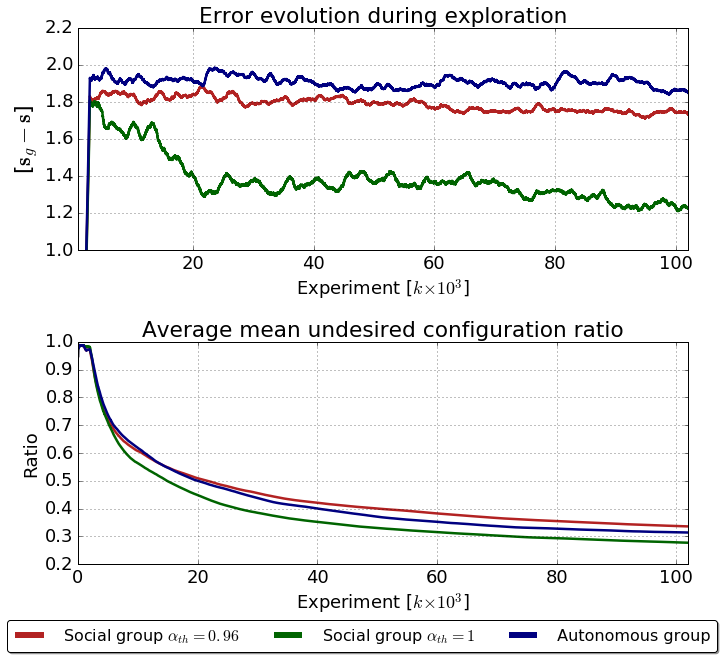

In [4]:
matplotlib.rcParams['figure.figsize'] = (10.0, 9)
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'lines.linewidth': 2.5})
win_sz=1000

x = np.linspace(0, len(moving_av(comp_av_w[comp_av_w.keys()[0]],win_sz)), \
                len(moving_av(comp_av_w[comp_av_w.keys()[0]],win_sz)))
scale_x = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))

fig1, ax1 = plt.subplots(2,1)
plt.sca(ax1[0])
ax1[0].set_title('Error evolution during exploration')

for key, color in zip(error_ev_av.keys(), colors_):
    data_plt = moving_av(comp_av_w[key],win_sz)
    ax1[0].plot(data_plt, linestyle='-', marker='', color=color)
ax1[0].set_xlabel('Experiment [$k$' + r'$\times$' + '$10^3$]')
ax1[0].set_ylabel(r'[$\mathbf{s}_g-\mathbf{s}$]',size=22)
ax1[0].set_xlim([1000,n_samples])
ax1[0].set_ylim([1.,2.2])
ax1[0].xaxis.set_major_formatter(ticks_x)

plt.sca(ax1[1])
ax1[1].set_title('Average mean undesired configuration ratio')
for key, color in zip(error_ev_av.keys(), colors_):
    data_plt = incremental_mean(coll_av_w[key])
    ax1[1].plot(data_plt, linestyle='-', marker='',color=color)
ax1[1].set_xlabel('Experiment [$k$' + r'$\times$' + '$10^3$]')
ax1[1].set_ylabel('Ratio')
ax1[1].set_xlim([0,n_samples])
# ax1[1].set_ylim([0.25,1])
ax1[1].xaxis.set_major_formatter(ticks_x)

lds_ = []
for key, color in zip(error_ev_av.keys(), colors_):
    key = key.replace('_autonomous',' Autonomous group')
    key = key.replace('_social',' Social group')
    key = key.replace('proprio','')
    key = key.replace('1', r' $\alpha _{th}=1$')
    key = key.replace('_96', r' $\alpha _{th}=0.96$')
    lds_ += [key]

lgd = plt.legend(lds_,\
            ncol=3,loc='lower right',fontsize=16, bbox_to_anchor=(1.06, -.43),
          fancybox=True, shadow=True)

for legobj in lgd.legendHandles:
    legobj.set_linewidth(6.0)
for ax in ax1:
    ax.grid(True)
plt.tight_layout()


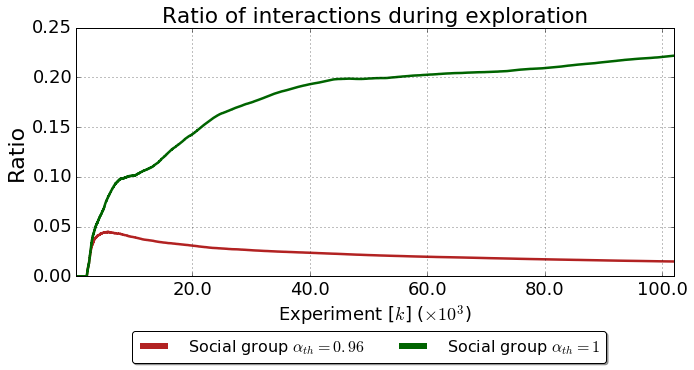

In [5]:
matplotlib.rcParams['figure.figsize'] = (10.0, 5.)
matplotlib.rcParams.update({'font.size': 18})

fig2, ax2 = plt.subplots(1,1)
plt.sca(ax2)
ax2.set_title('Ratio of interactions during exploration')
win_sz=100
lgds_ = []
for key, color in zip(inter_av.keys(), colors_): 
    if 'autonomous' in key:
        continue
    lgds_ += [key]
    data_plt = incremental_mean(inter_av[key])
    plt.plot(data_plt, linestyle='-', marker='', lw = 2.5, color=color)
plt.xlabel(r'Experiment [$k$] ($\times 10^3$)')
plt.ylabel(r'Ratio', size=22)
ax2.set_xlim([200,n_samples+1])
ax2.set_ylim([0,0.25])
ticks = ax2.get_xticks()*10**-3
ax2.set_xticklabels(ticks)

lds_ = []
for key, color in zip(error_ev_av.keys(), colors_):
    key = key.replace('_autonomous',' Autonomous group')
    key = key.replace('_social',' Social group')
    key = key.replace('proprio','')
    key = key.replace('1', r' $\alpha _{th}=1$')
    key = key.replace('_96', r' $\alpha _{th}=0.96$')
    lds_ += [key]

lgd = plt.legend(lds_,\
            ncol=3,loc='lower right',fontsize=16, bbox_to_anchor=(0.9, -.38),
          fancybox=True, shadow=True)

for legobj in lgd.legendHandles:
    legobj.set_linewidth(6.0)

ax2.grid(True)
plt.tight_layout()

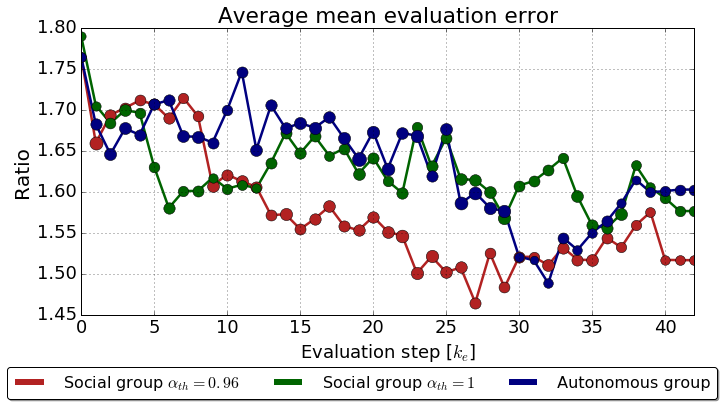

In [6]:
matplotlib.rcParams['figure.figsize'] = (10.0, 5.5)
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'lines.linewidth': 2.5})


fig3, ax3 = plt.subplots(1,1)
plt.sca(ax3)
ax3.set_title('Average mean evaluation error')
for key, color in zip(error_ev_av.keys(), colors_):
    data_plt = error_ev_av[key]
    ax3.plot(data_plt, linestyle='-', marker='', color=color)
for key, color in zip(error_ev_av.keys(), colors_):
    data_plt = error_ev_av[key]
    ms = [(x/max_std)*13 + 1 for x in std_ev[key]]
    std_markers(ax3,error_ev_av[key],'o',ms,color=color)
plt.xlabel('$k_{eval}$')
plt.ylabel('$e_{av}$')
# ax3.set_ylim([1.3,1.8])
ax3.set_xlim([0,42])
plt.xlabel('Evaluation step [$k_e$]')
plt.ylabel(r'Ratio',size=20)
# ax3.set_xlim([0,len(data_plt)-1])
# ax3.set_ylim([0.07,0.15]) 

# plt.sca(ax3[1])
# ax3[1].set_title('Average mean evaluation error')
# for key, color in zip(error_ev_av.keys(), colors_):
#     data_plt = cons_ev_whole_av[key]
#     ax3[1].plot(data_plt, linestyle='-', marker='', color=color)
# for key, color in zip(error_ev_av.keys(), colors_):
#     data_plt = cons_ev_whole_av[key]
#     ms = [(x/max_std)*13 + 1 for x in std_cons_ev_whole[key]]
#     std_markers(ax3[1],error_ev_av[key],'o',ms,color=color)
# plt.xlabel('$k_{eval}$')
# plt.ylabel('$e_{av}$')
# # ax3.set_ylim([1.3,1.8])
# ax3[1].set_xlim([0,42])
# plt.xlabel('Evaluation step [$k_e$]')
# plt.ylabel(r'Ratio')
# ax3[1].set_xlim([0,len(data_plt)-1])
# ax3[1].set_ylim([0.07,0.15]) 

lds_ = []
for key, color in zip(error_ev_av.keys(), colors_):
    key = key.replace('_autonomous',' Autonomous group')
    key = key.replace('_social',' Social group')
    key = key.replace('proprio','')
    key = key.replace('1', r' $\alpha _{th}=1$')
    key = key.replace('_96', r' $\alpha _{th}=0.96$')
    lds_ += [key]
    
lgd = plt.legend(lds_,\
            ncol=3,loc='lower right',fontsize=16, bbox_to_anchor=(1.05, -.32),
          fancybox=True, shadow=True)

for legobj in lgd.legendHandles:
    legobj.set_linewidth(6.0)
    
ax3.grid(True)
# ax3[1].grid(True)
plt.tight_layout()


In [7]:
# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/vt_results_evo_96.eps',
#              format='eps', dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')
# fig2.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/vt_results_inter_96.eps',
#              format='eps', dpi=1000, bbox_inches='tight')
# fig3.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/vt_results_eval_96.eps',
#              format='eps', dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')

In [11]:
for key in comp_av_w.keys():
    print key
    print np.mean(comp_av_w[key])

proprio_social_96
1.7578265423921282
proprio_social1
1.3572884433310446
proprio_autonomous
1.8741052775602387


In [12]:
for key in error_ev_av.keys():
    print key
    print incremental_mean(coll_av_w[key])[-1]

proprio_social_96
0.3359084967320728
proprio_social1
0.27719362745098935
proprio_autonomous
0.3138861655773392


In [16]:
n_exp = 102000
#container for convex hulls
ch_ = create_dict(groups_k)
ch_av = create_dict(groups_k)
ch_std = create_dict(groups_k)

#container for unarticulated productions
means_unart_s = create_dict(groups_k)
means_unart_av_s = create_dict(groups_k)
stds_unar_s = create_dict(groups_k)

#container for coarticulated productions
means_coart_s = create_dict(groups_k)
means_coart_av_s = create_dict(groups_k)
stds_coar_s = create_dict(groups_k)

for directory in directories:
    
    data_files = os.listdir(directory)
    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = directory + data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
        conf = read_config_log(conf_file)
        
        try:
            conf.update({'slope': conf['instructor_slope']+''})
        except:
            pass
        
        if 'IEEE_SI' in directory and conf['slope'] not in '0.96_1.0' and conf['mode']=='social':
            continue
        if 'simple' in conf['type'] :
            continue
        
        if conf['slope'] == '1.0' and conf['mode']=='social':
            conf['mode'] += '1' 
        if conf['slope'] == '0.96' and conf['mode']=='social':
            conf['mode'] += '_96'
        
        
        key = conf['type'] + '_' + conf['mode']
        
        data,foo = load_sim_h5(data_file)
        sensor_data = data.sensor.data.as_matrix(columns=None)

        ch_[key] += [ConvexHull(sensor_data[:,[0,1,3,4]],qhull_options='Q12').volume]
        means_unart_s[key] += [float(np.where(np.logical_xor(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1))[0].shape[0])/float(n_exp)]
        means_coart_s[key] += [float(np.where(np.logical_and(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1))[0].shape[0])/float(n_exp)]


In [18]:
legend = []
max_std = 0
for i, group in enumerate(groups_k):
    legend += [group]
    group = group[0] + '_' + group[1]

    ch_av[group] = np.mean(np.array(ch_[group]))
    ch_std[group] = np.std(np.array(ch_[group]))
    
    means_unart_av_s[group] = np.mean(np.array(means_unart_s[group]))
    stds_unar_s[group] = np.std(np.array(means_unart_s[group]))

    means_coart_av_s[group] = np.mean(np.array(means_coart_s[group]))
    stds_coar_s[group] = np.std(np.array(means_coart_s[group]))

lds_ = []
for key, color in zip(error_ev_av.keys(), colors_):
    key = key.replace('_autonomous',' Autonomous group')
    key = key.replace('_social',' Social group')
    key = key.replace('proprio','')
    key = key.replace('1', r' $\alpha _{th}=1$')
    key = key.replace('_96', r' $\alpha _{th}=0.96$')
    lds_ += [key]
print(lds_)

[' Social group $\\alpha _{th}=0.96$', ' Social group $\\alpha _{th}=1$', ' Autonomous group']


In [19]:
ch_av

{'proprio_autonomous': 1.0430497049820673,
 'proprio_social1': 0.9973075683398039,
 'proprio_social_96': 1.007373109508113}

In [20]:
means_unart_av_s

{'proprio_autonomous': 0.5305413943355118,
 'proprio_social1': 0.4644934640522876,
 'proprio_social_96': 0.45489978213507626}

In [21]:
means_coart_av_s

{'proprio_autonomous': 0.13588671023965138,
 'proprio_social1': 0.3293888888888889,
 'proprio_social_96': 0.2255942265795207}

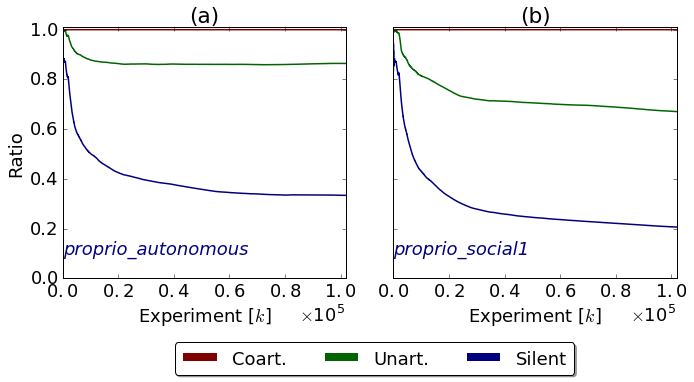

In [23]:
n_exp =102000
matplotlib.rcParams['figure.figsize'] = (10.0, 5)
matplotlib.rcParams.update({'font.size': 18})

#container for unarticulated productions
means_unart_s = create_dict(groups_k)
means_unart_av = create_dict(groups_k)

#container for coarticulated productions
means_coart_s = create_dict(groups_k)
means_coart_av = create_dict(groups_k)

for directory in directories:
    data_files = os.listdir(directory)
    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = directory + data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
        conf = read_config_log(conf_file)
        
        try:
            conf.update({'slope': conf['instructor_slope']+''})
        except:
            pass
        
        if 'IEEE_SI' in directory and conf['slope'] != '0.96' and conf['mode']=='social':
            if conf['slope'] != '1.0':
                continue
        if 'simple' in conf['type'] :
            continue
        
        if conf['slope'] == '1.0' and conf['mode']=='social':
            conf['mode'] += '1' 
        if conf['slope'] == '0.96' and conf['mode']=='social':
            conf['mode'] += '_96'
        
        key = conf['type'] + '_' + conf['mode']
        
        data,foo = load_sim_h5(data_file)
        sensor_data = data.sensor.data.as_matrix(columns=None)

        means_unart_s[key] += [(np.logical_xor(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1)).astype(np.float)[:n_exp]]
        means_coart_s[key] += [(np.logical_and(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1)).astype(np.float)[:n_exp]]

xfmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((-3,3))
        
def empty_yticks(ax):
    labels = [item.get_text() for item in ax.get_yticklabels()]
    return ['']*len(labels)

fig, ax = plt.subplots(1,2)
for key, selector in zip(groups_k[::-1],[0,1]):
    key = key[0]+ '_' + key[1] 
    plt.sca(ax[selector])
    means_unart_av[key] = np.mean(np.array(means_unart_s[key]), axis=0)
    means_coart_av[key] = np.mean(np.array(means_coart_s[key]), axis=0)

    data_plt_coart = incremental_mean(means_coart_av[key])
    data_plt_unart = incremental_mean(means_unart_av[key])
    data_plt_silence  = np.array([1-x for x in np.add(data_plt_coart,data_plt_unart)])

#     data_plt_unart = np.add(data_plt_coart,data_plt_unart)
#     data_plt_silence = np.add(data_plt_silence,data_plt_unart)

    data_plt_unart = np.add(data_plt_silence,data_plt_unart)
    data_plt_coart = np.add(data_plt_coart,data_plt_unart)

    plt.plot(data_plt_coart, linestyle='-', marker='',lw = 1.5,color='maroon')
    plt.plot(data_plt_unart, linestyle='-', marker='',lw = 1.5,color='darkgreen')
    plt.plot(data_plt_silence, linestyle='-', marker='',lw = 1.5,color='navy')

    plt.gca().xaxis.set_major_formatter(xfmt)
    plt.xlabel('Experiment [$k$]')
    plt.xlim([0,n_exp])
    plt.ylim([0,1.01])
    ax[selector].text(-1.0,0.1, key,color ='navy', style='italic')
    
for (let, selector) in zip(['a','b'],[0,1]):
    plt.sca(ax[selector])
    plt.title('(' + let + ')')
ax[1].set_yticklabels(empty_yticks(ax[1]))
ax[0].set_ylabel('Ratio')

plt.sca(ax[1])
lgd = plt.legend(['Coart.', 'Unart.', 'Silent'],\
           ncol=3,loc='lower right', fontsize=18, bbox_to_anchor=(.67, -0.42),
          fancybox=True, shadow=True)
plt.tight_layout()
for legobj in lgd.legendHandles:
    legobj.set_linewidth(8.0)

In [36]:
# fig.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter6/images/vt_proportions_96.eps',\
#              format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [10]:
for key in coll_s.keys():
    print key
    print np.array(coll_s[key]).shape

proprio_social_96
(18, 323, 16)
proprio_social1
(12, 323, 16)
proprio_autonomous
(18, 323, 16)
